In [2]:
from ddpm_conditional import *

n = 10
device = "cuda:0"
model = UNet_conditional(num_classes=10).to(device)
ckpt = torch.load("conditional_ema_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device)
y = torch.Tensor([6] * n).long().to(device)
x = diffusion.sample(model, n, y, cfg_scale=3)
plot_images(x)

RuntimeError: Error(s) in loading state_dict for UNet_conditional:
	Unexpected key(s) in state_dict: "label_emb.weight". 

torch.Size([12, 1, 64, 64])


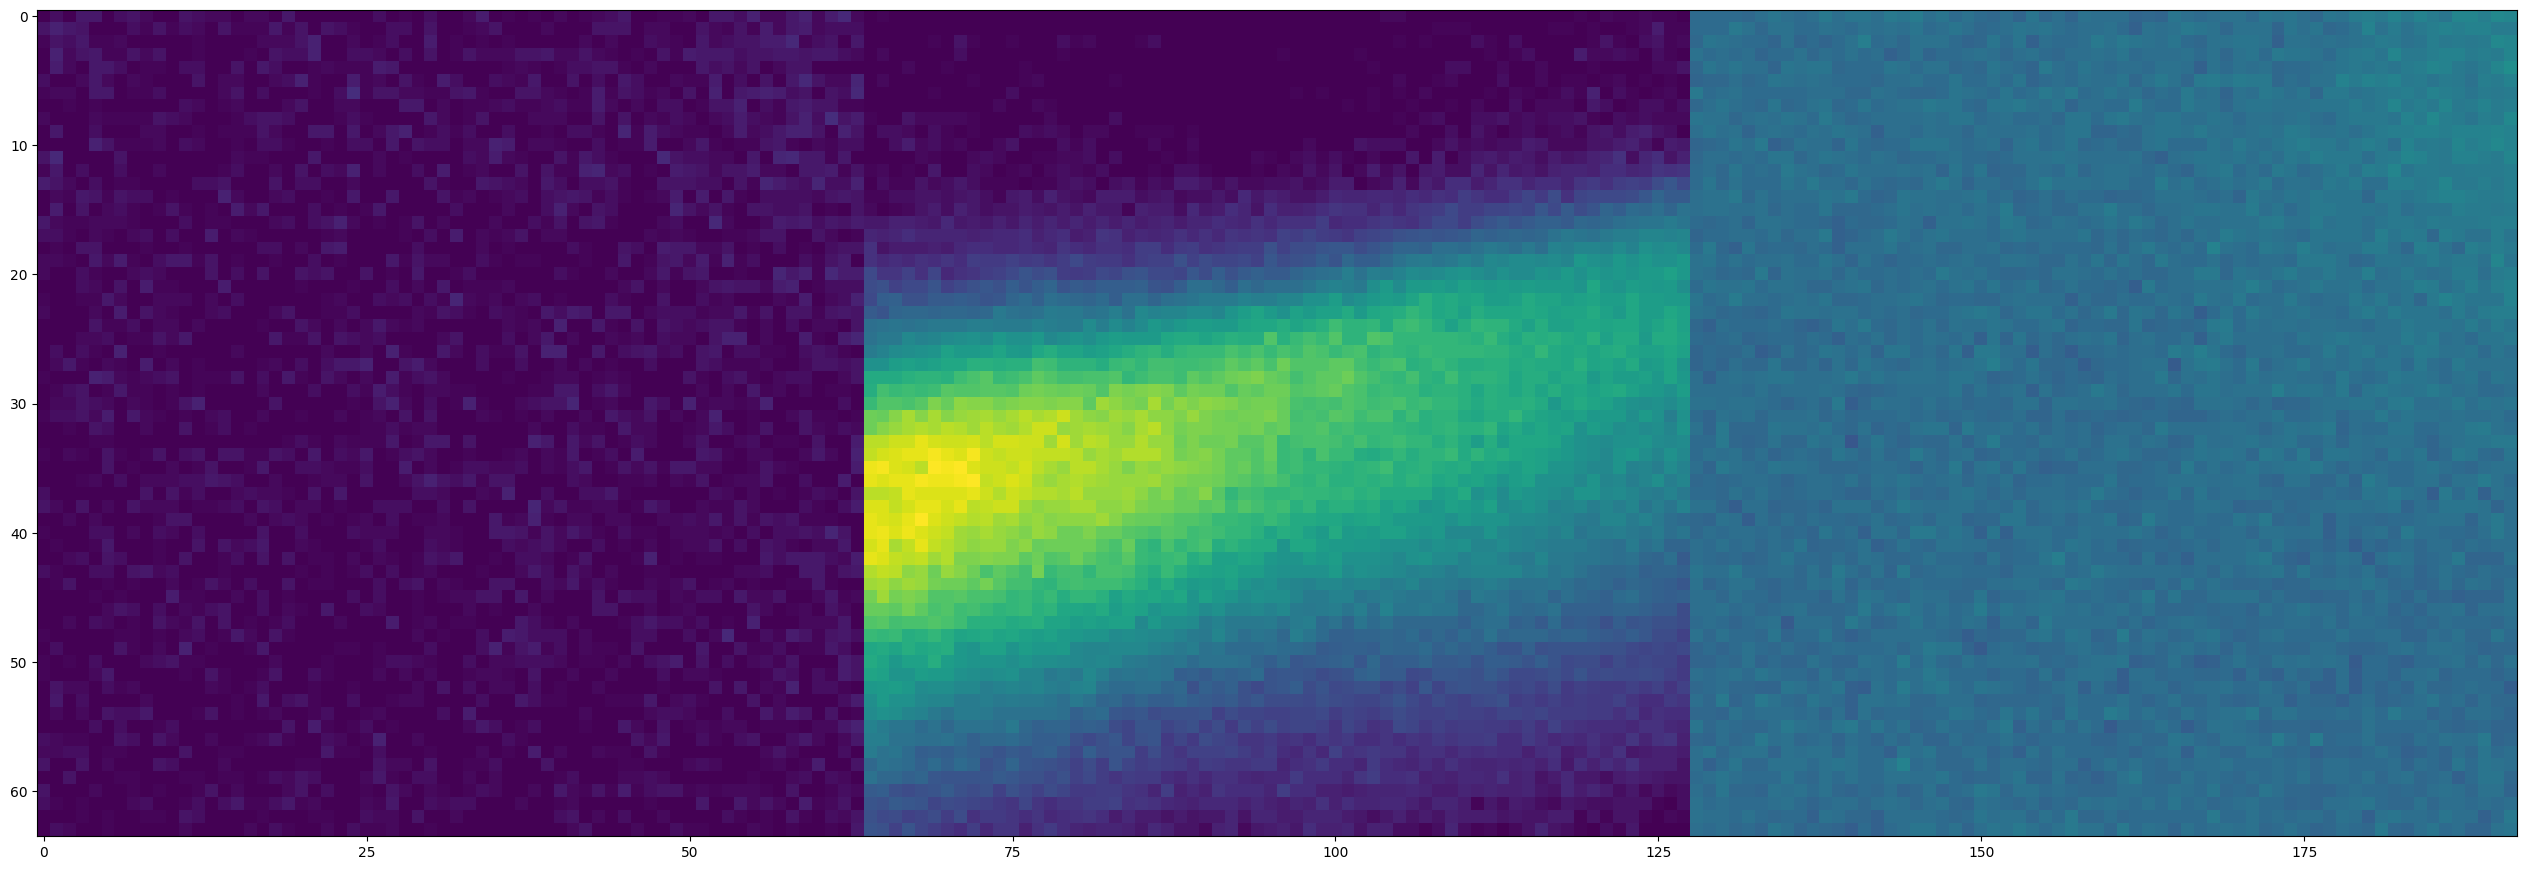

In [25]:
print(x.shape)
plot_images(x[8:11, :, :, :])